# COMP4318/5318 Assignment 2: Image Classification

### Group number: 94
# 这里的代码都是自个写的队友没参与。主要是参考了课上给的一些参照用代码实现的简单做法

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [141]:
'''
ALL 3 FUNCTIONS ARE IMPLEMENTED BY CHONG AN.
'''

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from collections import Counter,OrderedDict

from time import time

#1 RF
from sklearn.model_selection import train_test_split,StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

#2 MLP
import keras_tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

#3 CNN
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten

In [83]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [86]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
Training labels shape: (50000,)
Test labels shape: (10000,)
Pixel data type: uint8
Pixel value range: 0  ~  255
Number of unique classes: 10
Sample count per class: Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
Class label mapping:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck
Per-channel mean (R, G, B): [125.30691805 122.95039414 113.86538318]
Per-channel std (R, G, B): [62.99321928 62.08870764 66.70489964]


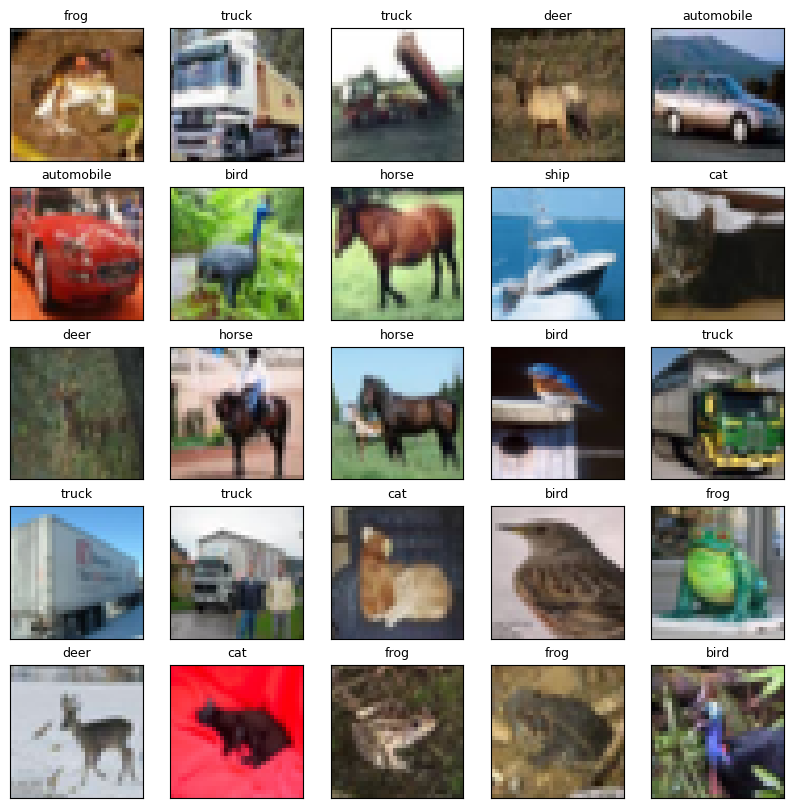

In [88]:
'''
Basic Infos.
'''
# 1. Basic Information 
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

# For CIFAR-10, the expected image dimension is (50000, 32, 32, 3)
# Check with print(X_train[0].shape)

#2. Data Type and Value Range 
print("Pixel data type:", X_train.dtype)
print("Pixel value range:", X_train.min(), " ~ ", X_train.max())

#3. Class Statistics
unique_classes = np.unique(y_train)
class_counts = Counter(y_train)
print("Number of unique classes:", len(unique_classes))
print("Sample count per class:", class_counts)

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
print("Class label mapping:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

#4 Channel stats
means = X_train.mean(axis=(0,1,2))
stds = X_train.std(axis=(0,1,2))
print("Per-channel mean (R, G, B):", means)
print("Per-channel std (R, G, B):", stds)

# 5 Visualize samples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    label_index = y_train[i] if np.ndim(y_train) == 1 else y_train[i][0]
    plt.title(class_names[label_index], fontsize=9)

plt.show()


In [89]:
#Preprocess Normalization
'''
Designed to Normalize RGB values from [0,255] to [0,1], usually this one will be enough.

According to Lecture and Internet There was another progress: (X-mean)/std.

However I rejected this wheen discussing with my friends, because it is not obvious when 3 params are of the same range value.

After this Normalization, your mean should be approximately goes to 0(Which is reflexed by about e-11)
And your std should be close to 1.
'''

X_train = X_train / 255.0
X_test  = X_test / 255.0
#These astype change was designed to fit Tensorflow and Pytorch.

means = X_train.mean(axis=(0,1,2))
stds = X_train.std(axis=(0,1,2))
print("Per-channel mean after normalization(R,G,B):", means)
print("Per-channel std after normalization(R,G,B):", stds)

Per-channel mean after normalization(R,G,B): [0.49139968 0.48215841 0.44653091]
Per-channel std after normalization(R,G,B): [0.24703223 0.24348513 0.26158784]


## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [158]:
# Note that train cases are X_train, y_train. 
'''These are used in RF'''
SAMPLE_SIZE = 2000 #Small sample used for PCA and algorithm choice.
RANDOM_STATE = 42  #Default
PCA_VARIANCE = 0.8 #This is tested for Speed.
N_JOBS = -1  # Use all available CPU cores
VARIANCE_RATIOS = [0.8]
cvKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)


def bestRFClassifier(X_train,y_train,X_test,y_test):
    #We already accepted X_train Y_train as input.
    #RF need a flattened input.
    X_flat = X_train.reshape(X_train.shape[0],-1)
    X_test_flat = X_test.reshape(X_test.shape[0],-1)   #Testing F1 scores.
    
    param_dist = {
        'rf__n_estimators': [80, 100, 120,300,500],      #The more N may be the better?
        'rf__max_depth': [6, 8, 10], #According to datas not in report, having a depth more than 15 may lead to great overfitting. We strictly limit this.
        'rf__min_samples_split': [8,16,24,32,64],   
        'rf__min_samples_leaf': [8,16,32],   
        'rf__max_features': ['sqrt'],           
        'rf__max_samples': [0.6, 0.7,0.8,0.9,None],         
        'rf__bootstrap': [True]                
    }     #These need a pre font for pipelining
    cv = cvKFold

    #Using Pipeline is better for Hyperparameter tuning.
    print('Fitting')
    pipeline = Pipeline([('pca', PCA(n_components=PCA_VARIANCE)),
                         ('rf', RandomForestClassifier(random_state=RANDOM_STATE))])   #Using PCA is for reducing test time.

    
    Search = RandomizedSearchCV(pipeline,param_dist, n_iter=15, cv=10, scoring='accuracy',n_jobs=N_JOBS, random_state=RANDOM_STATE)
    #While some params may not fit directly, these are referenced with Step2.
    
    Search.fit(X_flat,y_train)
    print('Fitted')

    best_estimator = Search.best_estimator_
    print(f"Random Forest Best parameters: {Search.best_params_}")
    print(f"Random Forest Best CV accuracy: {Search.best_score_:.4f}")
    

    
    y_pred = best_estimator.predict(X_test_flat)
    # print(f'Accuracy:{accuracy_score(y_test, y_pred)}')
    # print(f"F1 macro score:{f1_score(y_test, y_pred, average='macro')}")
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f'Macro average F1:{f1_macro}')
    print(f'Macro weighted F1:{f1_weighted}')
    

    return Search.best_params_

def final_RF(best_params):
    rf_params = {k.replace('rf__', ''): v for k, v in best_params.items()}   #These are for putting everything in my final model.
    rf_params['random_state'] = RANDOM_STATE
    rf_params['n_jobs'] = N_JOBS
    
    model = RandomForestClassifier(**rf_params)
    return model

def evaluate_RF(model,X_train,y_train,X_test,y_test):
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train model
    model.fit(X_train_flat, y_train)
    
    # Evaluate performance
    train_accuracy = model.score(X_train_flat, y_train)
    test_accuracy = model.score(X_test_flat, y_test)
    

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Overfitting: {train_accuracy - test_accuracy:.4f}")
    

### Fully connected neural network

In [94]:
'''FNN/NLP goees with a flattened input.'''
def MLP_build(hp):


    #Other tuning
    '''Tuning:
    learning rate:[1e-2,1e-3, 3e-4]
    l2 weight:[0.0,1e-4]
    '''
    learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3, 3e-4])  #0.01,0.001,0.0003
    l2w=hp.Choice("l2w",values=[0.0,1e-4])                                #0 or 0.0001

    #Basic input
    model = keras.models.Sequential([
        keras.layers.Input([32,32,3]),
        keras.layers.Flatten(),
    ])

    #Layer1
    '''Tuning:
        hidden_units:[256, 512,768]
        Activation:["relu", "tanh"]
        l2 weight:[0.0,1e-4]
        Dropout:[0.2,0.4]
    '''
    model.add(keras.layers.Dense(units=hp.Choice("units_1", values=[256, 512,768]),
                                 activation=hp.Choice("activation1", values=["relu", "tanh"]),
                                 kernel_regularizer=keras.regularizers.l2(l2w)
        )
    )
    model.add(keras.layers.Dropout(hp.Choice('dropout_1',[0.2,0.4])))

    
    #Layer2
    '''Tuning:
    hidden_units:[256, 512,768]
    Activation:["relu", "tanh"]
    l2 weight:[0.0,1e-4]
    Dropout:[0.2,0.4]
    '''
    model.add(keras.layers.Dense(units=hp.Choice("units_2", values=[256, 512,768]),
                                 activation=hp.Choice("activation2", values=["relu", "tanh"]),
                                 kernel_regularizer=keras.regularizers.l2(l2w)
        )
    )
    model.add(keras.layers.Dropout(hp.Choice('dropout_2',[0.2,0.4])))

    
    #Output Layer
    model.add(keras.layers.Dense(10, activation="softmax"))



    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def MLP_tune(X_train,y_train):
    X_TR, X_valid, y_TR, y_valid = train_test_split(X_train, y_train, train_size=0.9,random_state=RANDOM_STATE)
    tuner = keras_tuner.RandomSearch(
        hypermodel=MLP_build,
        objective="val_accuracy",
        max_trials=30,     #This should be higher to Validate results. Different from Tutorial we added up to 30 times.
        executions_per_trial=1,
        overwrite=True,
        directory="keras_tuning_results",
        project_name="Ass2"
    )
    tuner.search_space_summary()
    
    tuner.search(X_TR, y_TR, epochs=30,batch_size=256, validation_data=(X_valid, y_valid),callbacks=[keras.callbacks.EarlyStopping(patience=5)])
    #Using Patience is for faster tuning.
    
    tuner.results_summary()
    best_model = tuner.get_best_models()[0]
    best_hps = tuner.get_best_hyperparameters()[0]

    return best_model,best_hps

### Convolutional neural network

In [96]:
# def build_cnn(filters1=32, filters2=64, dropout=0.3):
#     model = keras.Sequential([
#         keras.Input(shape=(32, 32, 3)),

#         keras.layers.Conv2D(filters1, (3,3), activation="relu", padding="same"),
#         keras.layers.MaxPooling2D((2,2)),

#         keras.layers.Conv2D(filters2, (3,3), activation="relu", padding="same"),
#         keras.layers.MaxPooling2D((2,2)),

#         keras.layers.Flatten(),
#         keras.layers.Dropout(dropout),
#         keras.layers.Dense(10, activation="softmax")
#     ])
#     return model

# #Making validation samples
# CNNX_tr, CNNX_val, CNNy_tr, CNNy_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

#Ignore these, for referencing↑
'''FNN/NLP goees with a flattened input.'''
def CNN_build(hp):


    #Other tuning
    '''Tuning:
    learning rate:[1e-2,1e-3, 3e-4]
    l2 weight:[0.0,1e-4]
    '''
    learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3, 3e-4])  #0.01,0.001,0.0003
    l2w=hp.Choice("l2w",values=[0.0,1e-4])                                #0 or 0.0001

    #Basic input. No flattening.
    model = keras.models.Sequential([
        keras.layers.Input([32,32,3]),
    ])

    #Layer1
    '''Tuning:
        filters:[32,64,128]
        Activation:["relu", "tanh"]
        l2 weight:[0.0,1e-4]
        kernal_size:[3, 5]
    '''
    model.add(keras.layers.Conv2D(filters=hp.Choice("filters_1", values=[32,64,128]),
                                 kernel_size=hp.Choice("kernel_size_1", values=[3, 5]),
                                 activation=hp.Choice("activation1", values=["relu", "tanh"]),
                                 kernel_regularizer=keras.regularizers.l2(l2w)
        )
    )
    
    model.add(keras.layers.MaxPooling2D((2,2)))

    
    #Layer2
    '''Tuning:
        filters:[64,128,256]
        Activation:["relu", "tanh"]
        l2 weight:[0.0,1e-4]
        kernal_size:[3, 5]
    '''
    model.add(keras.layers.Conv2D(filters=hp.Choice("filters_2", values=[64,128,256]),
                                 kernel_size=hp.Choice("kernel_size_2", values=[3, 5]),
                                 activation=hp.Choice("activation2", values=["relu", "tanh"]),
                                 kernel_regularizer=keras.regularizers.l2(l2w)
        )
    )
    
    model.add(keras.layers.MaxPooling2D((2,2)))

    
    #Output Layer:Flatten, Full connection, Output
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
        units=hp.Choice("dense_units", values=[128, 256, 512]),
        activation=hp.Choice("dense_activation", values=["relu", "tanh"]),
        kernel_regularizer=keras.regularizers.l2(l2w)
    ))
              
    model.add(keras.layers.Dense(10, activation="softmax"))



    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def CNN_tune(X_train,y_train):
    X_TR, X_valid, y_TR, y_valid = train_test_split(X_train, y_train, train_size=0.9,random_state=RANDOM_STATE)
    tuner = keras_tuner.RandomSearch(
        hypermodel=CNN_build,
        objective="val_accuracy",
        max_trials=30,     #This should be higher to Validate results. Different from Tutorial we added up to 30 times.
        executions_per_trial=1,
        overwrite=True,
        directory="keras_tuning_results",
        project_name="Ass2"
    )
    tuner.search_space_summary()
    
    tuner.search(X_TR, y_TR, epochs=30,batch_size=256, validation_data=(X_valid, y_valid),callbacks=[keras.callbacks.EarlyStopping(patience=6)])
    #Using Patience is for faster tuning.
    
    tuner.results_summary()
    best_model = tuner.get_best_models()[0]
    best_hps = tuner.get_best_hyperparameters()[0]

    return best_model,best_hps

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [160]:
'''
This may take 10+ Minutes.
'''
Sample_X=X_train[:SAMPLE_SIZE]
sample_y=y_train[:SAMPLE_SIZE]
RFparams = bestRFClassifier(Sample_X,sample_y,X_test,y_test) #Shorten Tuning time.

Fitting
Fitted
Random Forest Best parameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 16, 'rf__min_samples_leaf': 8, 'rf__max_samples': 0.6, 'rf__max_features': 'sqrt', 'rf__max_depth': 10, 'rf__bootstrap': True}
Random Forest Best CV accuracy: 0.3640
Macro average F1:0.3566742460441296
Macro weighted F1:0.35667424604412956


### Fully connected neural network

In [101]:
MLPmodel,MLPhps = MLP_tune(X_train,y_train)

Trial 30 Complete [00h 00m 33s]
val_accuracy: 0.43540000915527344

Best val_accuracy So Far: 0.5353999733924866
Total elapsed time: 00h 18m 08s
Results summary
Results in keras_tuning_results\Ass2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 10 summary
Hyperparameters:
learning_rate: 0.0003
l2w: 0.0
units_1: 256
activation1: tanh
dropout_1: 0.2
units_2: 768
activation2: relu
dropout_2: 0.4
Score: 0.5353999733924866

Trial 18 summary
Hyperparameters:
learning_rate: 0.0003
l2w: 0.0
units_1: 768
activation1: relu
dropout_1: 0.2
units_2: 256
activation2: tanh
dropout_2: 0.4
Score: 0.5019999742507935

Trial 09 summary
Hyperparameters:
learning_rate: 0.0003
l2w: 0.0001
units_1: 768
activation1: relu
dropout_1: 0.4
units_2: 256
activation2: relu
dropout_2: 0.2
Score: 0.49720001220703125

Trial 19 summary
Hyperparameters:
learning_rate: 0.0003
l2w: 0.0001
units_1: 768
activation1: tanh
dropout_1: 0.2
units_2: 512
activation2: tanh
dropout_2: 0.4
Score: 0.495599

C:\Users\cfzjl\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Convolutional neural network

In [103]:
'''This may take 1h+.'''
CNNmodel,CNNhps = CNN_tune(X_train,y_train)

Trial 30 Complete [00h 02m 54s]
val_accuracy: 0.6714000105857849

Best val_accuracy So Far: 0.7300000190734863
Total elapsed time: 01h 33m 47s
Results summary
Results in keras_tuning_results\Ass2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
learning_rate: 0.001
l2w: 0.0001
filters_1: 128
kernel_size_1: 3
activation1: tanh
filters_2: 128
kernel_size_2: 3
activation2: relu
dense_units: 128
dense_activation: tanh
Score: 0.7300000190734863

Trial 00 summary
Hyperparameters:
learning_rate: 0.001
l2w: 0.0001
filters_1: 32
kernel_size_1: 3
activation1: tanh
filters_2: 256
kernel_size_2: 5
activation2: relu
dense_units: 512
dense_activation: relu
Score: 0.728600025177002

Trial 07 summary
Hyperparameters:
learning_rate: 0.001
l2w: 0.0001
filters_1: 128
kernel_size_1: 3
activation1: relu
filters_2: 256
kernel_size_2: 5
activation2: relu
dense_units: 128
dense_activation: relu
Score: 0.7121999859809875

Trial 13 summary
Hyperparameters

C:\Users\cfzjl\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [162]:
'''This will take few seconds.'''

RFmodel = final_RF(RFparams)
evaluate_RF(RFmodel,X_train,y_train,X_test,y_test)


Training Accuracy: 0.5906
Test Accuracy: 0.4297
Overfitting: 0.1609


### Fully connected neural network

In [164]:
mlp_train_acc = MLPmodel.evaluate(X_train, y_train, verbose=0)[1]
mlp_test_acc = MLPmodel.evaluate(X_test, y_test, verbose=0)[1]

print(f"MLP Training accuracy: {mlp_train_acc:.4f}")
print(f"MLP Test accuracy: {mlp_test_acc:.4f}")
print(f"Overfitting gap: {mlp_train_acc - mlp_test_acc:.4f}")


MLP Training accuracy: 0.6095
MLP Test accuracy: 0.5451
Overfitting gap: 0.0644


### Convolutional neural network

In [166]:
cnn_train_acc = CNNmodel.evaluate(X_train, y_train, verbose=0)[1]
cnn_test_acc = CNNmodel.evaluate(X_test, y_test, verbose=0)[1] #Not showing progress.
print(f"CNN Training accuracy: {cnn_train_acc:.4f}")
print(f"CNN Test accuracy: {cnn_test_acc:.4f}")
print(f"Overfitting gap: {cnn_train_acc - cnn_test_acc:.4f}")

CNN Training accuracy: 0.8473
CNN Test accuracy: 0.7216
Overfitting gap: 0.1257
